# Initialization

In [1]:
!pip install boto3

In [2]:
!pip install progressbar2

In [3]:
!pip install astropy

In [4]:
!pip install sfdmap

In [5]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V1')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [6]:
retrain = False
save_RF_dis_mat = False
save_RF_name = 'large_URF_100K_dataset'

if retrain:
    # create a save dir
    from datetime import datetime
    save_RF_dir = save_RF_name + '__' + datetime.now().strftime("%Y_%m_%d___%H_%M_%S")
else:
    save_RF_dir = 'large_URF_100K_dataset__2022_03_27___22_11_17/'
s3_urf_save_dir_path = os.path.join(s3_saves_dir_path, 'RF', save_RF_dir)
print('save folder (S3): ' + s3_urf_save_dir_path)

save folder (S3): almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/


# Train RF

## Loading data

In [7]:
# load data
print('Loading data and creating dataset')
X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path, 'spec.npy'))
wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path, 'wl_grid.npy'))
print('wavelength grid: {0}-{1} [A], length={2}.'.format(min(wl_grid),max(wl_grid),len(wl_grid)))

Loading data and creating dataset
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V1/spec.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V1/wl_grid.npy
wavelength grid: 3825.0-7725.0 [A], length=7800.


In [8]:
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs.pkl'))
gs_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs_train.pkl'))
gs_test = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs_test.pkl'))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs.pkl
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs_train.pkl
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V1/gs_test.pkl


## Create a test set for the URF

In [9]:
if retrain:
    # Need to create a 5K test set for the URF, which doesn't include the train and the test set we already split
    gs_remain = gs[~gs['specobjid'].isin(gs_train['specobjid'])]
    gs_remain = gs_remain[~gs_remain['specobjid'].isin(gs_test['specobjid'])]
    gs_URF_test = gs_remain.sample(5000, random_state=seed)
    I_test = gs_URF_test.index.to_list()
    I_train = gs.index.difference(gs_URF_test.index).to_list()
    
    print('Saving train/test indices')
    to_s3_npy(I_train, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'I_train.npy'))
    to_s3_npy(I_test, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'I_test.npy'))
else:
    print('Loading train/test indices')
    I_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'I_train.npy'))
    I_test = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'I_test.npy'))

Loading train/test indices
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/I_train.npy
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/I_test.npy


In [10]:
X_train = X[I_train]
X_test = X[I_test]

## Creating train and test sets for RF

In [11]:
if retrain:
    # creaet synthetic samples
    print('Creating synthetic data')
    from CustomRandomForest import return_synthetic_data
    from uRF_SDSS import merge_work_and_synthetic_samples

    X_train_syn = return_synthetic_data(X_train, seed)
    X_test_syn = return_synthetic_data(X_test, seed)

    Z_train, y_train = merge_work_and_synthetic_samples(X_train, X_train_syn)
    Z_test, y_test = merge_work_and_synthetic_samples(X_test, X_test_syn)

## Fit a random forest

In [12]:
from CustomRandomForest import CustomRandomForest
if retrain:
    # RF parameters
    N_trees = 500
    min_span = len(wl_grid)
    max_span = len(wl_grid)
    min_samples_split = 10000
    max_features = 'sqrt'
    max_samples = 1.0
    max_depth = 10
    N_snr_bins = 1

    # create a random forest
    rf = CustomRandomForest(N_trees=N_trees,
                            min_span=min_span,
                            max_span=max_span,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            max_samples=max_samples,
                            max_depth=max_depth
                           )

    # fit the forest to the data
    print('fitting RF...')
    rf.fit(Z_train, y_train, prefer="threads", n_jobs=16)
    print('done.')
    
else:
    print('Loading RF...')
    rf = CustomRandomForest.load_s3(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'crf.pkl'))
    print('done.')

Loading RF...
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/crf.pkl
done.


In [13]:
if retrain:
    # save the random forest
    print('Saving the random forest')
    rf.save_s3(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'crf.pkl'))

## Evaluate the RF

In [14]:
if retrain:
    print('Predict on training set')
    y_hat_train = rf.predict(Z_train)

    print('Predict on test set')
    y_hat_test = rf.predict(Z_test)

    print('Evaluating')
    from sklearn.metrics import classification_report
    train_set_report = classification_report(y_train, y_hat_train)
    test_set_report = classification_report(y_test, y_hat_test)
    print('TRAININ-SET:')
    print(train_set_report )
    print('TEST-SET:')
    print(test_set_report)

In [15]:
if retrain:
    from s3 import log_s3
    log_s3(s3_client, bucket_name, path_in_bucket=s3_urf_save_dir_path, log_name='RF_log.txt',
        N_RF_train_real = sum(y_train==1),
        N_RF_train_syn = len(y_train)-sum(y_train==1),
        N_RF_test_real = sum(y_test==1),
        N_RF_test_syn = len(y_test)-sum(y_test==1),
        N_trees = rf.N_trees,
        min_span = rf.min_span,
        max_span = rf.max_span,
        min_samples_split = rf.min_samples_split,
        max_features = rf.max_features,
        max_samples = rf.max_samples,
        max_depth = rf.max_depth,
        train_set_report = '\n'+train_set_report,
        test_set_report = '\n'+test_set_report
        )

###  Plots

In [16]:
if retrain:
    p_test = rf.predict_proba(Z_test)
    p_train = rf.predict_proba(Z_train)

    fig = plt.figure()
    plt.hist(p_train[y_train==1,1], density=True, bins=20, alpha=0.5, label='train - real')
    plt.hist(p_train[y_train==2,2], density=True, bins=20, alpha=0.5, label='train - synthetic')
    plt.hist(p_test[y_test==1,1], density=True, bins=20, alpha=0.5, label='test - real')
    plt.hist(p_test[y_test==2,2], density=True, bins=20, alpha=0.5, label='test - synthetic')
    plt.legend()
    plt.title("probability distribution soft predictions")
    plt.ylabel("Pr")
    plt.xlabel("predicted probability")

    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'prob_dist.png'))

## Calculate similarity matrix, weirdness scores and T-SNE

In [17]:
if retrain:
    print('Applying the RF on the full dataset (real spectra only)')
    X_train_leaves = rf.apply(X_train).astype(np.float32)

    print('Predicting fully')
    Y_train_hat = rf.predict_full_from_leaves(X_train_leaves).astype(np.float32)
    
    print('Saving the data')
    to_s3_npy(X_train_leaves, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'X_train_leaves.npy'))
    to_s3_npy(Y_train_hat, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'Y_train_hat.npy'))
else:
    print('loading the data')
    X_train_leaves = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'X_train_leaves.npy'))
    Y_train_hat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'Y_train_hat.npy'))

loading the data
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/X_train_leaves.npy
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/Y_train_hat.npy


In [18]:
retrain=True

In [19]:
if retrain:
    print('Calculating the distance matrix')
    from CustomRandomForest import build_similarity_matrix
    sim_mat = build_similarity_matrix(X_train_leaves, Y_train_hat)
    print('Calculating the distance matrix')
    dist_mat = 1-sim_mat
    del sim_mat

    if save_RF_dis_mat:
        print('Saving the distance matrix')
        to_s3_npy(dist_mat, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'dist_mat.npy'))
else:
    if save_RF_dis_mat:
        print('Loading the distance matrix')
        dist_mat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'dist_mat.npy'))

Calculating the distance matrix


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 4544 tasks      | e

assembling the matrix.
Calculating the distance matrix


In [20]:
if retrain:
    print('Calculating the weirdness scores')
    weird_scores = np.mean(dist_mat, axis=1)

    print('Saving the weirdness scores')
    to_s3_npy(weird_scores, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'weird_scores.npy'))
else:
    print('Loading the weirdness scores')
    weird_scores = from_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'weird_scores.npy'))

Calculating the weirdness scores
Saving the weirdness scores
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/weird_scores.npy


In [21]:
if retrain:
    print('Running T-SNE')
    from sklearn.manifold import TSNE
    sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dist_mat)

    print('Saving T-SNE')
    to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'tsne.npy'))
else:
    print('Loading T-SNE')
    sne = to_s3_npy(s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'tsne.npy'))

Running T-SNE


/storage/home/almogh/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 95000 samples in 72.380s...
[t-SNE] Computed neighbors for 95000 samples in 190.588s...
[t-SNE] Computed conditional probabilities for sample 1000 / 95000
[t-SNE] Computed conditional probabilities for sample 2000 / 95000
[t-SNE] Computed conditional probabilities for sample 3000 / 95000
[t-SNE] Computed conditional probabilities for sample 4000 / 95000
[t-SNE] Computed conditional probabilities for sample 5000 / 95000
[t-SNE] Computed conditional probabilities for sample 6000 / 95000
[t-SNE] Computed conditional probabilities for sample 7000 / 95000
[t-SNE] Computed conditional probabilities for sample 8000 / 95000
[t-SNE] Computed conditional probabilities for sample 9000 / 95000
[t-SNE] Computed conditional probabilities for sample 10000 / 95000
[t-SNE] Computed conditional probabilities for sample 11000 / 95000
[t-SNE] Computed conditional probabilities for sample 12000 / 95000
[t-SNE] Computed conditional probabilities for 

# Plots

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/weirdness_scores_histogram.png


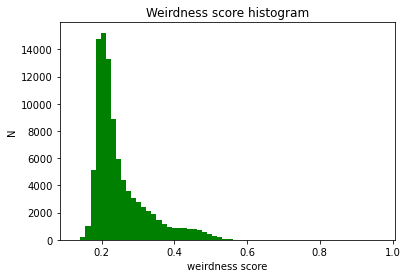

In [22]:
if retrain:
    fig = plt.figure()
    tmp = plt.hist(weird_scores, bins=60, color="g")
    plt.title("Weirdness score histogram")
    plt.ylabel("N")
    plt.xlabel("weirdness score")

    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'weirdness_scores_histogram.png'))

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/distances_histogram.png


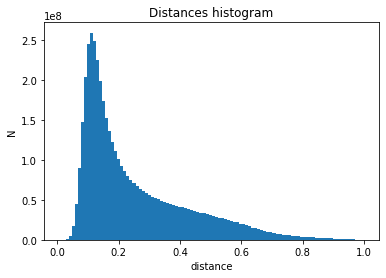

In [23]:
if retrain:

    fig = plt.figure()
    tmp = plt.hist(dist_mat[np.tril_indices(dist_mat.shape[0], -1)], bins=100)
    plt.title("Distances histogram")
    plt.ylabel("N")
    plt.xlabel("distance")

    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'distances_histogram.png'))

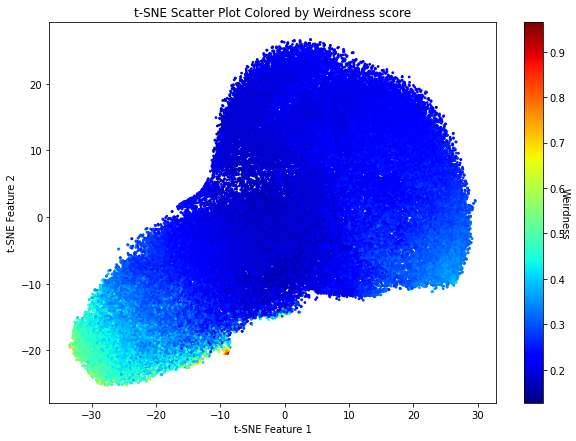

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/tsne_colored_by_weirdness.png


In [24]:
if retrain:
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    im_scat = ax.scatter(sne[:, 0], sne[:, 1], s=3, c=weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('Weirdness', rotation=270)
    plt.show()

    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'tsne_colored_by_weirdness.png'))

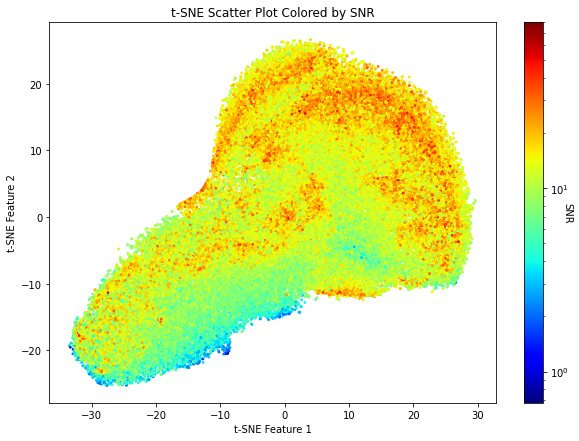

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/large_URF_100K_dataset__2022_03_27___22_11_17/tsne_colored_by_snr.png


True

In [26]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
import matplotlib.colors as colors
snr = gs.loc[I_train].snMedian
im_scat = ax.scatter(sne[:,0], sne[:,1], s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by SNR')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('SNR', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_urf_save_dir_path, 'tsne_colored_by_snr.png'))